In [5]:
import os
import numpy as np
import skimage
import imageio.v2 as imageio
import random
import matplotlib.pyplot as plt

import argparse
import json
import string
import shutil
import uuid
from captcha.image import ImageCaptcha
import itertools
import cv2
from random import choices
import zipfile

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import imageio.v2 as imageio

from itertools import chain
from sklearn import preprocessing

'from sklearn import preprocessing'

In [6]:
def set_deterministic(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
seed = 5 # any number 
set_deterministic(seed=seed)

# DATA GENERATION

In [4]:
alphabet_all = list('qwertyupasdfghjkzxcvbnm23456789QWERTYUPKJHGFDSAZXCVBNM')
alphabet = list('qwertyupasdfghjkzxcvbnm23456789')#QWERTYUIOPLKJHGFDSAZXCVBNM')
prev_alpha = ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
num_alphabet = len(prev_alpha)
def _gen_captcha(img_dir, num_of_letters, num_of_repetition, width, height):
    if os.path.exists(img_dir):
        shutil.rmtree(img_dir)
    if not os.path.exists(img_dir):
        os.makedirs(img_dir)

    image = ImageCaptcha(width=width, height=height)

    for counter in range(num_of_repetition):
        i = choices(prev_alpha, k=5)
        captcha = ''.join(i)
        fn = os.path.join(img_dir, '%s_%s.png' % (captcha, uuid.uuid4()))
        image.write(captcha, fn)


def gen_dataset(path, num_of_repetition, num_of_letters, width, height):
    _gen_captcha(os.path.join(path, 'data'), num_of_letters, num_of_repetition, width, height)
    print('Finished Data Generation')
     

In [5]:
NUM_OF_LETTERS = 5
IMG_ROW, IMG_COLS = 50, 200

# Non-configs
PATH = os.getcwd()
DATA_PATH = os.path.join(PATH, 'train')

In [6]:
def load_data(path, test_split=0.1):
    print ('loading dataset...')
    y_train = []
    y_test = []
    x_train = []
    x_test = []

    # r=root, d=directories, f = files
    counter = 0
    for r, d, f in os.walk(path):
        for fl in f:
            if '.png' in fl:
                flr = fl.split('_')[0]
                counter += 1
                label = np.zeros((NUM_OF_LETTERS, num_alphabet))
                for i in range(NUM_OF_LETTERS):
                    label[i, prev_alpha.index(flr[i].lower())] = 1
#                 label = np.zeros((50, 1))
#                 for i in range(5):
#                     label[i*5+int(flr[i])] = 1

                img = cv2.imread(os.path.join(r, fl))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (int(135/2), int(50/2)), interpolation=cv2.INTER_AREA)
                img = np.reshape(img, (img.shape[0], img.shape[1], 1))

                if random() < test_split:
                    y_test.append(label)
                    x_test.append(img)
                else:
                    y_train.append(label)
                    x_train.append(img)

    print('dataset size:', counter, '(train=%d, test=%d)' % (len(y_train), len(y_test)))
    return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

In [7]:


if not os.path.exists(DATA_PATH):
    print('Generating Dataset')
    gen_dataset(DATA_PATH, 10000 , NUM_OF_LETTERS, IMG_COLS, IMG_ROW)

Generating Dataset
Finished Data Generation


In [8]:
DATA_PATH = DATA_PATH+'/data'

In [9]:
for file in os.listdir(DATA_PATH):
    src = DATA_PATH + '/' + file
    dst = DATA_PATH + '/' + file[:5] + '.png'
    os.rename(src, dst)

# DATA LOADER

In [7]:
datadir = os.path.join(*[os.getcwd(), "data"])

In [8]:
datanames = os.listdir(datadir)
jpeg = ([img[:-4] for img in datanames if img[-4:]==".jpg"])
png = ([img[:-4] for img in datanames if img[-4:]==".png"])

In [9]:
class Captcha_Dataset(Dataset):
    def __init__(self, datadir, transform=None, preload=True, img_ext=['.png'], mode="train", split_rate=0.8, seed=0):
        self.datadir = datadir
        self.img_ext = img_ext
        self.preload = preload
        
        self.mode = mode
        self.split_rate = split_rate
        self.seed = 0
        
        if self.preload:
            data_list = os.listdir(self.datadir)
            self.data = []
            self.chars = []
            for im_name in os.listdir(self.datadir):
                if im_name[-4:] in self.img_ext:
                    img = imageio.imread(os.path.join(self.datadir, im_name))
                    if len(img.shape) == 3 and img.shape[2] == 3:
                        #img = skimage.color.rgba2rgb(img) # RGBA -> RGB
                        img = skimage.color.rgb2gray(img) # RGB -> Gray
                    if len(img.shape) == 2:
                        img = img
                    label = im_name[:-4]
                    label = list(label)
                    self.data.append((img, label))
            self.characters = list(set(chain.from_iterable((label) for _, label in self.data)))
            self.characters.sort()
            self.class_dict = dict(zip(self.characters, np.arange(len(self.characters))+1))
            self.inv_class_fict = {v: k for k,v in self.class_dict.items()}
            self.data = [(val,list(map(self.class_dict.get, labl))) for val,labl in self.data]
            # print(len(self.data))
            
            if mode=="train":
                self.data = self.data[:int(self.split_rate*len(self.data))]
            elif mode=="val":
                self.data = self.data[int(self.split_rate*len(self.data)):]
                
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x, y = self.data[index]
        # y=0
        x = torch.Tensor(x).unsqueeze(0)
        y = torch.Tensor(y)
        
        # y_letters = list(y) # Split word to letters
        
        
        if self.transform:
            pass
        return (x, y)
    
    def size(self):#ok
        for i in self.data:
            print(i[0].shape)

In [10]:
dataset_train = Captcha_Dataset(datadir=datadir, mode="train")
dataloader_train = DataLoader(dataset=dataset_train, batch_size=512, shuffle=True)

In [25]:
dataset_train.class_dict

{'2': 1,
 '3': 2,
 '4': 3,
 '5': 4,
 '6': 5,
 '7': 6,
 '8': 7,
 'b': 8,
 'c': 9,
 'd': 10,
 'e': 11,
 'f': 12,
 'g': 13,
 'm': 14,
 'n': 15,
 'p': 16,
 'w': 17,
 'x': 18,
 'y': 19}

In [15]:
x_batch, y_batch = next(iter(dataloader_train))

torch.Size([50, 200])


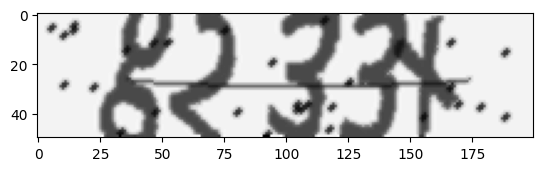

In [21]:
%matplotlib inline
print(x_batch[0,0].shape)
plt.imshow(x_batch[6,0], cmap=plt.cm.gray)
plt.show()

# CLASSIFICATION

In [11]:
# decoding process 
def decode_predictions_class(preds, encoder):
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j, :]:
            if k == 0:continue
            else:
                p = encoder[k]
                temp.append(p)
        cap_preds.append("".join(temp))
    return cap_preds
    
def eval_class(model, dataloader_test):    
    model.eval()
    predict = []
    gt = []
    imgs = []
    with torch.no_grad():
        for x, y in dataloader_test:
            x, y = x.to(device), y.to(device)
            y = F.one_hot(y.to(torch.int64), num_classes=len(dataloader_train.dataset.characters)+1)
            y_pred = model(x)
            f = decode_predictions_class(y_pred, dataloader_test.dataset.inv_class_fict)
            predict.extend(f)
            g = decode_predictions_class(y, dataloader_test.dataset.inv_class_fict)
            gt.extend(g)
            for k in range(y.size(0)):
                # s = "".join(dataloader_test.dataset.inv_class_fict[i.item()] for i in y[k])
                # gt.append(s)
                imgs.append(x[k].cpu().numpy())
    return predict, gt, imgs    

In [12]:
class Captcha_Model_classification(nn.Module): # constructed CNN
    def __init__(self, num_channel=1, char=dataset_train.characters):
        super(Captcha_Model_classification, self).__init__()
        self.channels = [64, 128, 256]

        self.encoder = nn.Sequential(
            nn.Conv2d(num_channel, self.channels[0], kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(self.channels[0], self.channels[0], kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(self.channels[0], self.channels[1], kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d(self.channels[1], self.channels[1], kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(self.channels[1], self.channels[2], kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.Conv2d( self.channels[2],  self.channels[2], kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(2, 2), 
            
            nn.Dropout(0.25),
            nn.Flatten(),
        )
        toy_data = torch.zeros(2,1,50,200)
        toy_out = self.encoder(toy_data)

        self.dense = nn.Sequential(
            nn.Linear(toy_out.shape[1], 512),
            nn.ReLU(),
            nn.Dropout(0.25),
            # nn.Linear(256, 256),
            )
        self.outs = torch.nn.ModuleList([nn.Linear(512, len(char) + 1) for _ in range(5)])

    def forward(self, x):
        device = x.device
        # print(img.size())
        x = self.encoder(x)
        x = self.dense(x)
        outs = [out(x).unsqueeze(0) for out in self.outs]
        outs = torch.cat(outs, dim=0)
        outs = outs.permute(1,0,2)
        return outs

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deep_capthca = Captcha_Model_classification().to(device)
print(device)
optimizer = torch.optim.Adam(deep_capthca.parameters(), lr=3e-4)
loss_func = nn.CrossEntropyLoss(reduction='sum')
loss_array = []
acc_array = []
epoch = 250
for ep in range(epoch):
    deep_capthca.train()
    loss_overall = 0.0

        
    predict = []
    gt = []
    imgs = []
    for x, y in dataloader_train:
        # print(x.shape)
        x, y = x.to(device), y.to(device)
        # print(y.shape)
        y = F.one_hot(y.to(torch.int64), num_classes=len(dataloader_train.dataset.characters)+1)

        
        optimizer.zero_grad()
        y_pred = deep_capthca(x)
        # print(y_pred.shape)
        # print(y.shape)
        loss = loss_func(y_pred, y.to(torch.float32))
        loss.backward()
        optimizer.step()
        loss_overall += loss.item()
    loss_array.append(loss_overall/len(dataloader_train.dataset))

    predict, gt, imgs = eval_class(deep_capthca, dataloader_train)
    pos = np.sum([p==g for p, g in zip(predict, gt)])
    acc_array.append(pos/len(predict))

    if ep%10==0 or ep==epoch-1:
        print("Epoch: {}, Loss: {}".format(ep, loss_overall/len(dataloader_train.dataset))) 
        print("Train Accuracy: ", pos/len(predict))
    # if ep%100==0:
    #     optimizer = torch.optim.Adam(cap.parameters(), lr=1e-4) # Resetting Momentum

cuda


[W NNPACK.cpp:51] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch: 0, Loss: 8.048658559127754
Train Accuracy:  0.0
Epoch: 10, Loss: 6.377247481329416
Train Accuracy:  0.000500751126690035
Epoch: 20, Loss: 2.619100739732646
Train Accuracy:  0.07323485227841763
Epoch: 30, Loss: 1.8111866362165319
Train Accuracy:  0.16537305958938409
Epoch: 40, Loss: 1.581322407806045
Train Accuracy:  0.2242113169754632
Epoch: 50, Loss: 1.4246243785844783
Train Accuracy:  0.2826740110165248
Epoch: 60, Loss: 1.3430208560521446
Train Accuracy:  0.3087130696044066
Epoch: 70, Loss: 1.283837843251694
Train Accuracy:  0.32811717576364546
Epoch: 80, Loss: 1.2336315141657799
Train Accuracy:  0.3731847771657486
Epoch: 90, Loss: 1.2014445160171898
Train Accuracy:  0.39208813219829747
Epoch: 100, Loss: 1.1702372131194838
Train Accuracy:  0.41374561842764146
Epoch: 110, Loss: 1.1341699133172416
Train Accuracy:  0.435277916875313
Epoch: 120, Loss: 1.1103848002227952
Train Accuracy:  0.45105157736604906
Epoch: 130, Loss: 1.0811995046402612
Train Accuracy:  0.45693540310465697
E

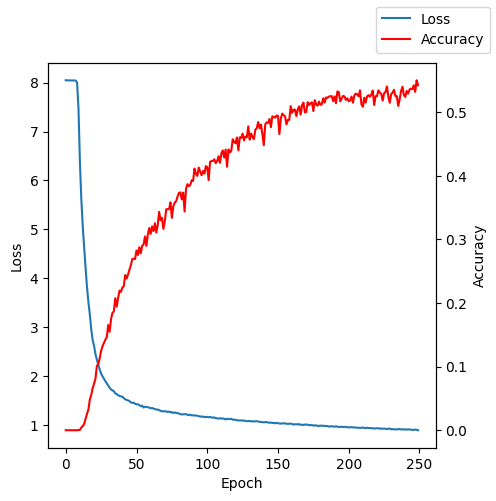

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(loss_array, label="Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

axs = ax.twinx()
axs.plot(acc_array, label="Accuracy", color="red")
axs.set_ylabel("Accuracy")
fig.legend()
plt.show()

In [15]:
datadir = os.path.join(*[os.getcwd(), "data"])
dataset_test = Captcha_Dataset(datadir=datadir, mode="val")
dataloader_test = DataLoader(dataset=dataset_test, batch_size=256, shuffle=False)
predict, gt, imgs = eval_class(deep_capthca, dataloader_test)
pos = np.sum([p==g for p, g in zip(predict, gt)])
print("Accuracy: ", pos/len(predict))

Accuracy:  0.05107661492238358


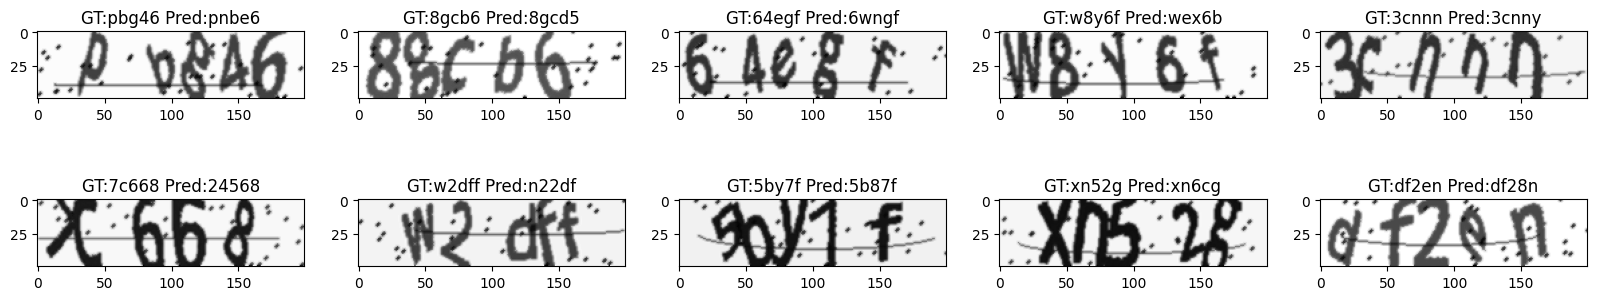

In [16]:
fig, ax = plt.subplots(2, 5, figsize=(20, 4))
for i in range(10):
    ax[i//5, i%5].imshow(imgs[i][0], cmap=plt.cm.gray)
    ax[i//5, i%5].set_title( f"GT:{ gt[i]} Pred:{predict[i]}")

In [17]:
torch.save(deep_capthca.state_dict(), "deep_captcha.pth")